In [1]:
# ─── CHALLENGE 1 ────────────────────────────────────────────────────────────────

from collections import defaultdict
from itertools import product
from math import prod
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

with open('input20') as file:
    tile_lines = file.read().split('\n\n')


class Tile():
    #
    # labeling of directions
    #          top
    #           0
    #           a
    #   left 3d   b1 right
    #           c
    #           2
    #          bot
    #
    def __init__(self, tile):
        self.flip_ac = False
        self.flip_bd = False
        self.rotate = False
        self.x = None
        self.y = None
        self.array = Tile.create_array(tile)
        self.parse_tile_string(tile)
        
    def set_state(self, rotate=None, toggle_rotate=None,
                  toggle_flip_ac=None, toggle_flip_bd=None,
                  flip_ac=None, flip_bd=None, inv=None,
                  x=None, y=None):
        if rotate is not None:
            self.rotate = rotate
        if toggle_rotate is not None:
            self.rotate = not self.rotate
        if flip_ac is not None:
            self.flip_ac = flip_ac
        if toggle_flip_ac is not None:
            self.flip_ac = not self.flip_ac
        if flip_bd is not None:
            self.flip_bd = flip_bd
        if toggle_flip_bd is not None:
            self.flip_bd = not self.flip_bd
        if inv is not None:
            self.inv = inv
        if x is not None:
            self.x = x
        if y is not None:
            self.y = y

    def move_edge_to_pos(self, edge, pos=0):
        # if edge is part of tile, this function will flip/rotate the tile,
        # so that edge will be moved to pos 
        assert self.rotate == False
        if self.get_edges()[pos] == edge:
            return
        self.set_state(flip_ac=True, flip_bd=True)
        if self.get_edges()[pos] == edge:
            return
        self.set_state(rotate=True)
        if self.get_edges()[pos] == edge:
            return
        self.set_state(flip_ac=False, flip_bd=False)
        if self.get_edges()[pos] == edge:
            return
        assert self.get_edges()[pos] == edge

    def flip_hor(self):
        if self.rotate:
            self.set_state(toggle_flip_ac=True)
        else:
            self.set_state(toggle_flip_bd=True)

    def flip_ver(self):
        if self.rotate:
            self.set_state(toggle_flip_bd=True)
        else:
            self.set_state(toggle_flip_ac=True)

    def parse_tile_string(self, tile):
        edge_b, edge_d = '', ''
        for i, tile_line in enumerate(tile.splitlines()):
            if i == 0:
                tile_idx = int(re.search('\d+', tile_line)[0])
                continue
            edge_d += tile_line[0]
            edge_b += tile_line[-1]
            if i == 1:
                edge_a = tile_line
            if i == 10:
                edge_c = tile_line
        self.idx = tile_idx
        print(edge_a, edge_b, edge_c, edge_d)
        self.parse_edges([edge_a, edge_b, edge_c, edge_d])

    @staticmethod
    def create_array(tile):
        new_array = np.zeros((10, 10))
        for y, line in enumerate(tile.splitlines()[1:]):
            bits = line.replace('#', '1').replace('.', '0')
            bits_list = [int(c) for c in bits]
            new_array[y,:] = bits_list
        return new_array

    def get_array(self):
        new_array = self.array.copy()
        if self.flip_ac:
            new_array = np.flip(new_array, 0)
        if self.flip_bd:
            new_array = np.flip(new_array, 1)
        if self.rotate:
            new_array = np.rot90(new_array, k=-1)
        return new_array
    
    def get_array_crop(self):
        # return array without edges
        return self.get_array()[1:-1,1:-1]

    def apply_tile_state(self, item):
        if self.flip_ac:
            item = [item[i] for i in [2,1,0,3]]
        if self.flip_bd:
            item = [item[i] for i in [0,3,2,1]]
        if self.rotate:
            item = [item[-1],*item[:-1]]
        return tuple(item)
            
    def get_edges(self):
        # returns edges in a,b,c,d orientation, according to the
        # current tile state
        return self.apply_tile_state(self.edges)

    def get_edge_counts(self):
        # returns edge counts in a,b,c,d orientation, according to 
        # the current tile state
        return self.apply_tile_state(self.edge_counter)

    def count_edges(self, dicts):
        edge_counter = []
        for h in self.edges:
            edge_counter.append(dicts[h])
        self.edge_counter = tuple(edge_counter)

    @staticmethod
    def calc_hash(string):
        # calculates a hash for each edge. needs to be the same hash if edge
        # is flipped
        print(string)
        hash1 = int(string, 2)
        hash2 = int(string[::-1], 2)
        return min(hash1, hash2)

    def parse_edges(self, edges):
        def str_replace(string):
            return string.replace('#', '1').replace('.', '0')
        # order is a,b,c,d (top,right,bot,left)        
        # turn each edge into binary string
        edges = list(map(str_replace, edges))
        edges = list(map(Tile.calc_hash, edges))
        self.edges = tuple(edges)


# ─── CREATE TILES ───────────────────────────────────────────────────────────────


edge_count_dict = defaultdict(int)
tiles = []
for tile in tile_lines:
    new_tile = Tile(tile)
    for e in new_tile.get_edges():
        edge_count_dict[e] += 1
    tiles.append(new_tile)

for tile in tiles:
    tile.count_edges(edge_count_dict)


# ─── FIND CORNER TILES ──────────────────────────────────────────────────────────


corner_idx = set()
for tile in tiles:
    counter_unique_edges = 0
    for num in tile.get_edge_counts():
        if num == 1:
            counter_unique_edges += 1
    if counter_unique_edges > 1:
        corner_idx.add(tile.idx)

assert prod(corner_idx) == 29584525501199
print('result 1: ', prod(corner_idx))

######..#. .#....#... ..#.#..... #...##.#..
1111110010
0100001000
0010100000
1000110100
.##.####.# ###.#...#. ##..##.#.. ..#.#.#..#
0110111101
1110100010
1100110100
0010101001
....###..# #..#.##... #####..#.. .#...##.##
0000111001
1001011000
1111100100
0100011011
#..#...### #.#.####.# ##....##.# ##.#.#####
1001000111
1010111101
1100001101
1101011111
.###.##.## ##.##.#### ...##.#### .######.#.
0111011011
1101101111
0001101111
0111111010
##.##..#.. .#.###.... #.#.###... #.#...##.#
1101100100
0101110000
1010111000
1010001101
.#.#.#...# ###..#...# .#.####.## ..###.#...
0101010001
1110010001
0101111011
0011101000
##.#...... .##.##..## .###.##..# #......##.
1101000000
0110110011
0111011001
1000000110
..####...# ####.##.#. .#.###.... ...####.#.
0011110001
1111011010
0101110000
0001111010
.#....#... ...###.... ...###.##. ...#.#....
0100001000
0001110000
0001110110
0001010000
.#..#....# ##.......# #.#.....## ..#.#.##.#
0100100001
1100000001
1010000011
0010101101
###..#..#. .##..#.#.# ..##.#..##

In [2]:
# ─── CHALLENGE 2 ────────────────────────────────────────────────────────────────

def get_tile_by_idx(idx):
    for tile in tiles:
        if tile.idx == idx:
            return tile
    assert False, 'tile not found'

def get_tile_by_pos(x, y):
    for tile in tiles:
        if tile.x == x:
            if tile.y == y:
                return tile
    assert False, 'tile not found'

def get_tiles_by_edge(current_idx, current_edge):
    for tile in tiles:
        if current_edge in tile.edges:
            if current_idx != tile.idx:
                return tile

def find_next_tile(current_idx, current_edge):
    # find tile that fits (only one tile will fit)
    new_tile = get_tiles_by_edge(current_idx, current_edge)
    
    # get edge on opp side
    edges = new_tile.edges
    current_hash_index = edges.index(current_edge)
    new_hash_index = (current_hash_index + 2) % 4
    new_edge = edges[new_hash_index]

    return new_tile.idx, new_edge

def find_row_of_tiles(current_idx, current_edge):
    # starting from one tile and one edge, this will return 11 additional
    # fitting tiles. These 11 tiles are distinct, as every edge occures 
    # 1 or 2 times (edge or connection)
    
    idx_list = [current_idx]
    for _ in range(11): # find 11 more, to have a line of 12
        current_idx, current_edge = find_next_tile(current_idx, current_edge)
        idx_list.append(current_idx)    
    return idx_list


# select first corner tile
current_idx = list(corner_idx)[0]
tile = get_tile_by_idx(current_idx) 
tile.set_state(x=0, y=0)

# flip tile vertically, so that unique edge is in top position
if tile.get_edge_counts()[0] != 1:
    tile.flip_ver()
assert tile.get_edge_counts()[0] == 1

# select bottom facing edge:
current_edge = tile.get_edges()[2]


# ─── STEP 1 ─────────────────────────────────────────────────────────────────────
#
# place correct tiles along left edge (X)
#  
# 0####
# X####
# X####
# X####
# X####
#


# find tiles on left edge
idx_list = find_row_of_tiles(current_idx, current_edge)

# apply tiles with correct a<->c orientation
for y, idx in enumerate(idx_list[1:], start=1):
    tile = get_tile_by_idx(idx)
    tile.set_state(x=0, y=y)
    tile.move_edge_to_pos(current_edge, 0)
    edges = tile.get_edges()
    current_edge = edges[2]

# apply correct b<->d orientation (unique edges face left)
for y in range(12): 
    x = 0
    tile = get_tile_by_pos(x, y)
    if tile.get_edge_counts()[3] != 1:
        tile.flip_hor()
    assert tile.get_edge_counts()[3] == 1


# ─── STEP 2 ─────────────────────────────────────────────────────────────────────
#
# place remaining tiles, row by row (Ys, then Zs, then ...)
#  
# 0YYYY
# XZZZZ
# X....
# X....
# X....
#


for y in range(12):
    # select starting tile
    tile = get_tile_by_pos(x=0, y=y)
    current_idx = tile.idx

    # select starting edge (right side)
    current_edge = tile.get_edges()[1]

    # find matching tiles:
    idx_list = find_row_of_tiles(current_idx, current_edge)
    
    # apply tiles with correct a<->c orientation
    for x, idx in enumerate(idx_list[1:], start=1):
        tile = get_tile_by_idx(idx)
        tile.set_state(x=x, y=y)
        tile.move_edge_to_pos(current_edge, 3)
        edges = tile.get_edges()
        current_edge = edges[1]
    

# ─── STEP 3 ─────────────────────────────────────────────────────────────────────
#
# fix orientation of top row
#

# flip top row vertically, so that unique edges face up
for x in range(1,12):
    tile = get_tile_by_pos(x=x, y=0)
    ec = tile.get_edge_counts()
    if ec[0] != 1:
        tile.flip_ver()
    ec = tile.get_edge_counts()
    assert ec[0] == 1
    
# ─── STEP 4 ─────────────────────────────────────────────────────────────────────
#
# make sure that vertical rows of tiles have matching edges
#

for x in range(1,12):
    tile = get_tile_by_pos(x=x, y=0)
    # get current edge (down facing)
    current_edge = tile.get_edges()[2]
    
    for y in range(1,12):
        tile = get_tile_by_pos(x=x, y=y)
        edges = tile.get_edges()
        new_edge = edges[0]
        if new_edge != current_edge:
            tile.flip_ver()
        new_edge = tile.get_edges()[0]
        assert new_edge == current_edge
        current_edge = tile.get_edges()[2]


# ─── STEP 5 ─────────────────────────────────────────────────────────────────────
#
# get assembled images (with and without edges)
#

assembled_image_full = np.zeros((10*12, 10*12), dtype=np.int)
for x,y in product(range(12), range(12)):
    tile = get_tile_by_pos(x=x, y=y)
    new_array = tile.get_array()
    assembled_image_full[y*10:(y+1)*10, x*10:(x+1)*10] = new_array

assembled_image = np.zeros((8*12, 8*12), dtype=np.int)
for x,y in product(range(12), range(12)):
    tile = get_tile_by_pos(x=x, y=y)
    new_array = tile.get_array_crop()
    assembled_image[y*8:(y+1)*8, x*8:(x+1)*8] = new_array


# ─── READ MONSTER ───────────────────────────────────────────────────────────────
monster_coords_xy = []
monster = """                  # 
#    ##    ##    ###
 #  #  #  #  #  #   """

for y, line in enumerate(monster.splitlines()):
    for x, c in enumerate(line):
        if c == '#':
            monster_coords_xy.append((x,y))


# ─── SEARCH MONSTER ─────────────────────────────────────────────────────────────
found_list_final = None
matrix_final = None
monster_counter_list = []
def start_monster_searche(matrix):
    global found_list_final
    global matrix_final
    monster_counter, found_list = find_sea_monsters(matrix)
    monster_counter_list.append(monster_counter)
    if monster_counter > 0:
        found_list_final = found_list
        matrix_final = matrix.copy()

def find_sea_monsters(matrix):
    monster_counter = 0
    found_list=[]
    for y_extra, x_extra in product(range(96-2), range(96-19)):
        hit_counter = 0
        for x, y in monster_coords_xy:
            if matrix[y+y_extra, x+x_extra] == 1:
                hit_counter += 1
        if hit_counter >= 15:  # found monster
            monster_counter += 1
            found_list.append((y_extra, x_extra))
    return monster_counter, found_list


for _ in range(4): # rotate
    # search | normal
    start_monster_searche(assembled_image)
    # flip right | only right
    assembled_image = np.flip(assembled_image, axis=0)
    start_monster_searche(assembled_image)
    # flip top   | both flips 
    assembled_image = np.flip(assembled_image, axis=1)
    start_monster_searche(assembled_image)
    # flip right | only top
    assembled_image = np.flip(assembled_image, axis=0)
    start_monster_searche(assembled_image)
    # flip top   | back to normal
    assembled_image = np.flip(assembled_image, axis=1)
    # rotate
    assembled_image = np.rot90(assembled_image)

result = np.count_nonzero(assembled_image)-max(monster_counter_list)*len(monster_coords_xy)
assert result == 1665
print('result 2: ', result)

<ipython-input-2-a72824ecc337>:164: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assembled_image_full = np.zeros((10*12, 10*12), dtype=np.int)
<ipython-input-2-a72824ecc337>:170: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
De

result 2:  1665


assembled image (with alligned edges)


[]

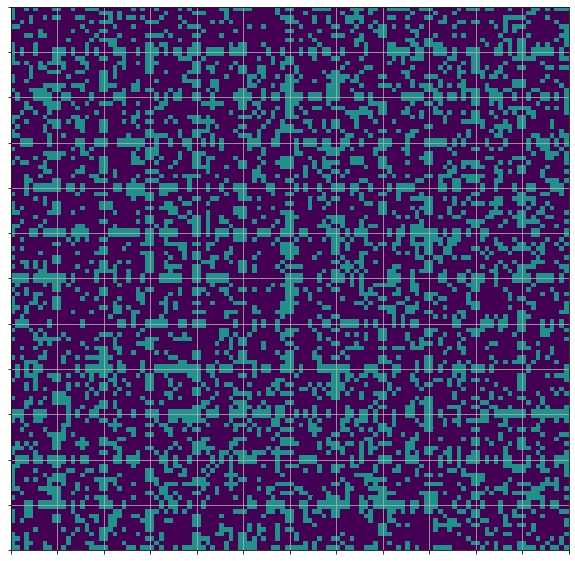

In [3]:
# ─── VIS ────────────────────────────────────────────────────────────────────────

for y_extra, x_extra in found_list_final:
    for x, y in monster_coords_xy:
        matrix_final[y+y_extra, x+x_extra] = 2

print('assembled image (with alligned edges)')
plt.figure(figsize=(10,10))
plt.pcolormesh(assembled_image_full, vmax=2)
plt.grid(True)
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.gca().yaxis.set_major_locator(MultipleLocator(10))
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

assembled image (without alligned edges) with detected monsters


[]

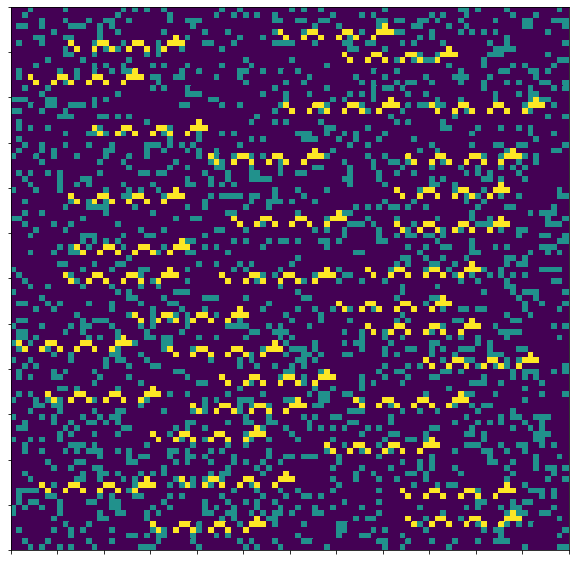

In [4]:
print('assembled image (without alligned edges) with detected monsters')
plt.figure(figsize=(10,10))
plt.pcolormesh(matrix_final)
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_locator(MultipleLocator(8))
plt.gca().yaxis.set_major_locator(MultipleLocator(8))
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])